In [522]:
import pandas as pd
import numpy as np
import random as rng

# Settings

In [523]:
data_filepath = "PaintShop - September 2024.xlsx"
data_sheet_names_by_table_name = {
    "orders": "Orders", 
    "machines": "Machines", 
    "setups": "Setups"
}   

# Data

In [524]:
data = {table_name: pd.read_excel(data_filepath, sheet_name) for table_name, sheet_name in data_sheet_names_by_table_name.items()}

# We keep the soource data in a dictionary in order to prevent confusion about what tables are source and what are derived.
orders = pd.read_excel(data_filepath, sheet_name = "Orders")
machine_speeds = pd.read_excel(data_filepath, sheet_name = "Machines")
setups = pd.read_excel(data_filepath, sheet_name = "Setups")

In [525]:
data["orders"]

,Order,Surface,Colour,Deadline,Penalty
0,O1,150,Green,18,10
1,O2,200,Yellow,28,12
2,O3,180,Blue,12,8
3,O4,170,Blue,15,15
4,O5,130,Yellow,36,9
5,O6,160,Blue,33,11
6,O7,140,Green,35,14
7,O8,210,Yellow,38,13
8,O9,190,Blue,32,7
9,O10,120,Green,41,10


In [526]:
data["machines"].head()

,Machine,Speed
0,M1,20
1,M2,25
2,M3,18


In [527]:
data["setups"]

,From colour,To colour,Setup time
0,Green,Red,6
1,Yellow,Green,2
2,Green,Yellow,5
3,Yellow,Red,1
4,Red,Yellow,8
5,Red,Green,5
6,Blue,Red,8
7,Blue,Yellow,10
8,Blue,Green,4
9,Green,Blue,3


### Prepare data

In [528]:
machine_speeds = {
    id: speed 
    for id, speed 
    in zip(data["machines"].index, data["machines"]["Speed"])
}
machine_speeds

{0: 20, 1: 25, 2: 18}

In [529]:
machine_ids = data["machines"].index.values

In [530]:
# Encode color names for efficiency, set ID as index
unique_colors = data["setups"]["From colour"].unique()
color_names_by_index = pd.DataFrame({
    "name": [c_name for c_name in unique_colors]
}, index = range(len(unique_colors)))
color_names_by_index

,name
0,Green
1,Yellow
2,Red
3,Blue


In [531]:
# Encode color names in setups
setups = pd.DataFrame({
    "c1":   data["setups"]["From colour"].apply(lambda from_color: color_names_by_index[color_names_by_index["name"] == from_color].index[0]),
    "c2":   data["setups"]["To colour"  ].apply(lambda to_color:   color_names_by_index[color_names_by_index["name"] == to_color  ].index[0]),
    "time": data["setups"]["Setup time" ]
})
setups

,c1,c2,time
0,0,2,6
1,1,0,2
2,0,1,5
3,1,2,1
4,2,1,8
5,2,0,5
6,3,2,8
7,3,1,10
8,3,0,4
9,0,3,3


In [532]:
# Fix orders table: encode colors and set order index as index
orders = pd.DataFrame(
    {
        "surface": data["orders"]["Surface"].values,
        "color": [color_names_by_index[color_names_by_index["name"] == c].index[0] for c in data["orders"]["Colour"]],
        "deadline": data["orders"]["Deadline"].values,
        "penalty": data["orders"]["Penalty"].values,
    },
    index = data["orders"].index
)
orders  

,surface,color,deadline,penalty
0,150,0,18,10
1,200,1,28,12
2,180,3,12,8
3,170,3,15,15
4,130,1,36,9
5,160,3,33,11
6,140,0,35,14
7,210,1,38,13
8,190,3,32,7
9,120,0,41,10


In [533]:
def first_or_0(list):
    if len(list) == 0:
        return 0
    return list[0] 

# Create table of order-to-order setup times.
setup_times = pd.DataFrame({ 
    order1_id: pd.Series([
        0 if (order1_id == order2_id) else
        first_or_0(setups.loc[
            (setups["c1"] == orders.loc[order1_id, "color"]) &
            (setups["c2"] == orders.loc[order2_id, "color"]),
            "time"
        ].values) for order2_id in orders.index.values
    ], dtype="Int64") for order1_id in orders.index.values 
}).transpose()

# Display table
setup_times

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,5,3,3,5,3,0,5,3,0,...,6,0,3,6,0,5,3,0,5,6
1,2,0,11,11,0,11,2,0,11,2,...,1,2,11,1,2,0,11,2,0,1
2,4,10,0,0,10,0,4,10,0,4,...,8,4,0,8,4,10,0,4,10,8
3,4,10,0,0,10,0,4,10,0,4,...,8,4,0,8,4,10,0,4,10,8
4,2,0,11,11,0,11,2,0,11,2,...,1,2,11,1,2,0,11,2,0,1
5,4,10,0,0,10,0,4,10,0,4,...,8,4,0,8,4,10,0,4,10,8
6,0,5,3,3,5,3,0,5,3,0,...,6,0,3,6,0,5,3,0,5,6
7,2,0,11,11,0,11,2,0,11,2,...,1,2,11,1,2,0,11,2,0,1
8,4,10,0,0,10,0,4,10,0,4,...,8,4,0,8,4,10,0,4,10,8
9,0,5,3,3,5,3,0,5,3,0,...,6,0,3,6,0,5,3,0,5,6


In [534]:
process_times = pd.DataFrame({
    machine_id: [
        order_surface / machine_speed for order_surface in orders["surface"].values
    ] for machine_id, machine_speed in machine_speeds.items()
})
process_times

,0,1,2
0,7.5,6.0,8.333333
1,10.0,8.0,11.111111
2,9.0,7.2,10.000000
3,8.5,6.8,9.444444
4,6.5,5.2,7.222222
5,8.0,6.4,8.888889
6,7.0,5.6,7.777778
7,10.5,8.4,11.666667
8,9.5,7.6,10.555556
9,6.0,4.8,6.666667


### Functions

### Classes

In [535]:
class Schedule:
    """A class representing a solution to the paintshop-problem. This is essentially a wrapper for it's internal dict[int, list[int]] object (.order_queue) with some usefull functions.
    """
    
    
    # Constructor. Example call: "Solution()".
    def __init__(self):
        """Constructs an empty solution.
        """
        self.order_queue = {
            i: [] for i in machine_ids
        }
    
    # Index getter. Example call: "Solution()[i]".
    def __getitem__(self, machine_id: int) -> list[int]:
        """Gets the queue for the machine with the specified machine-number

        Args:
            machine_id (int): The index of the machine.

        Returns:
            list[int]: The queue for the specified machine.
        """
        return self.order_queue[machine_id]
    
    # Index setter. Example call: "Solution()[i] += [1]"
    def __setitem__(self, machine_id: int, queue: list[int]):
        """Sets the queue for the machine with the specified machine-number

        Args:
            machine_id (int): The index of the machine.
            queue (list[int]): The queue for the specified machine.
        """
        self.order_queue[machine_id] = queue
    
    # String conversion. Example call: "print(Schedule())" or "str(Schedule())"
    def __str__(self) -> str:
        
        return f"Cost: \t{self.get_cost():.2f}\n" + '\n'.join([f'M{machine_id + 1}: {self.order_queue[machine_id]} ({self.get_cost_machine(machine_id):.2f})' for machine_id in machine_ids])
    
    # Returns the solution in pandas.DataFrame form
    def to_dataframe(self) -> pd.DataFrame:
        """Returns the Solution converted to a pandas.DataFrame.

        Returns:
            pd.DataFrame: The Solution in dataframe form.
        """
        
        return pd.DataFrame.from_dict(
            self.order_queue,
        ).rename(columns ={
            machine_id: f"M{machine_id + 1}" 
            for machine_id in machine_ids
        })
        
    # Return the time at which the machine with the specified ID finishes it's order queue
    def get_finish_time(self, machine_id: int) -> float:
        
        # Processing time when starting on the current order
        t = 0
        last_order_id = None
        
        # Iterate over orders in queue
        for order_id in self.order_queue[machine_id]:
            
            # Add processing time to current time
            t += process_times.loc[order_id, machine_id]
            
            # Add setup time
            if (last_order_id != None):
                t += setup_times.loc[last_order_id, order_id]
            
            # Update last order ID
            last_order_id = order_id
            
        return t
    
    def get_cost_machine(self, machine_id):
        # Processing time when starting on the current order
        t = 0
        last_order_id = None
            
        # Initialize penalty
        total_penalty = 0
            
        # Iterate over orders in queue
        for order_id in self.order_queue[machine_id]:
            
            # Add processing time to current time
            t += process_times.loc[order_id, machine_id]
            
            # Add setup time
            if (last_order_id != None):
                t += setup_times.loc[last_order_id, order_id]
            
            # Add penalty to total_cost
            if (t > orders.loc[order_id, 'deadline']):
                total_penalty += orders.loc[order_id, 'penalty'] * (t - orders.loc[order_id, 'deadline'])
            
            # Update last order ID
            last_order_id = order_id
        
        return total_penalty
    
    # Returns the total cost of the solution
    def get_cost(self) -> float:
        """Returns the total penalty for this schedule.

        Returns:
            float: The total penalty
        """
        
        # Initialize penalty
        total_penalty = 0
        
        # Iterate over machines in schedule
        for machine_id in self.order_queue.keys():
            
            total_penalty += self.get_cost_machine(machine_id)
        
        # Return total penalty
        return total_penalty
                

# Solution

In [536]:
def heuristic_constructive_simple() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # For each order (ordered by order-number ascending).
    for order_id in orders.index.values:
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            machine_ids, 
            key = lambda i:
                len(schedule[i]) +
                i / len(machine_speeds)
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next] += [order_id]
        
    return schedule

In [537]:
def heuristic_constructive_simple_2() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # For each order (ordered by order-number ascending).
    for order_id in orders.index.values:
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            machine_ids, 
            key = lambda i:
                schedule.get_finish_time(i) + 
                i / len(machine_speeds), 
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next] += [order_id]
        
    return schedule

In [538]:
def heuristic_constructive_simple_3() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    # For each order (ordered by order-number ascending).
    for order_id in sorted(orders.index.values, key = lambda order_id: orders.loc[order_id, 'deadline']):
        
        # Determine machine index with the shortest queue (adding a machine's index (scaled to a fraction) works like the tiebreaking rule).
        machine_id_next = sorted(
            machine_ids, 
            key = lambda i:
                schedule.get_finish_time(i) + 
                i / len(machine_speeds), 
        )[0]
        
        # Add order to machine queue.
        schedule[machine_id_next] += [order_id]
        
    return schedule

In [539]:
def heuristic_constructive_random() -> Schedule:
    """Constructs a solution according to the following heuristic:
    1. Create an empty solution. (Empty lists (representing order-numbers) by machine-numbers in a dictionary)
    2. Assign the order with the lowest order-number to the machine with the lowest amount of assigned orders, adding it to the end to the order-queue for that machine. The tiebreaking rule is that the machine with the lowest machine-number gets the order.
    3. Go to step 2 unless all orders are assigned.
    
    Returns:
        dict[int, list[int]]: The constructed solution. 
    """
    
    
    # Construct an empty solution dictionary.
    schedule = Schedule()
    
    order_ids_remaining = orders.index.values
    
    while len(order_ids_remaining) > 0:
        
        next_order_id_index = rng.choice(range(len(order_ids_remaining)))
        
        schedule[rng.choice(machine_ids)] += [order_ids_remaining[next_order_id_index]]
        
        order_ids_remaining = np.delete(order_ids_remaining, next_order_id_index)      
    return schedule

In [540]:
print('\n\n'.join([
    f"{schedule}" for heuristic, schedule in {
        "constructive_simple": heuristic_constructive_simple(),
        "constructive_simple_2": heuristic_constructive_simple_2(),
        "constructive_simple_3": heuristic_constructive_simple_3(),
        "constructive_random": heuristic_constructive_random()
    }.items()
]))

Cost: 	1414.11
M1: [0, 3, 6, 9, 12, 15, 18, 21, 24, 27] (565.00)
M2: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28] (222.00)
M3: [2, 5, 8, 11, 14, 17, 20, 23, 26, 29] (627.11)

Cost: 	2815.77
M1: [0, 3, 7, 12, 14, 17, 20, 22, 25, 29] (760.50)
M2: [1, 4, 6, 9, 10, 13, 15, 19, 21, 24, 26, 28] (1440.60)
M3: [2, 5, 8, 11, 16, 18, 23, 27] (614.67)

Cost: 	4181.39
M1: [2, 10, 6, 7, 13, 19, 18, 16, 28, 23] (1632.50)
M2: [3, 11, 8, 4, 12, 15, 14, 26, 25, 21, 29] (1445.00)
M3: [0, 1, 5, 9, 24, 20, 17, 27, 22] (1103.89)

Cost: 	10287.93
M1: [22, 17, 20, 29, 25, 23, 16, 18, 27, 0, 24, 21] (4118.00)
M2: [11, 14, 19, 26, 8, 12, 1, 15, 2, 9, 4] (3354.60)
M3: [7, 5, 28, 6, 3, 10, 13] (2815.33)


In [541]:
random_schedules = sorted([heuristic_constructive_random() for i in range(2000)], key = lambda schedule: schedule.get_cost())

In [542]:
print(random_schedules[0])

Cost: 	4658.54
M1: [25, 7, 0, 18, 8, 26, 16, 6, 28, 22] (1131.50)
M2: [4, 1, 11, 14, 24, 23, 12, 9, 21, 17, 15, 5, 20] (2299.60)
M3: [3, 10, 27, 2, 19, 13, 29] (1227.44)


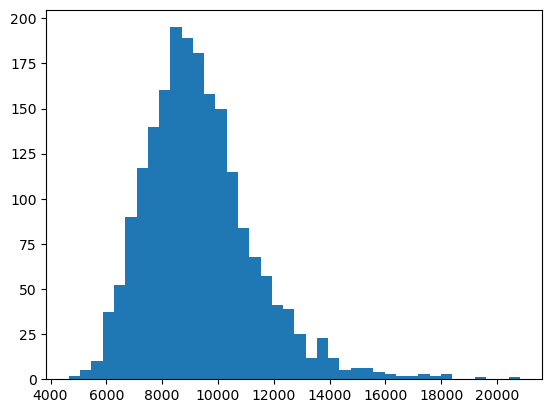

In [545]:
import matplotlib.pyplot as plt

plt.hist([s.get_cost() for s in random_schedules], bins = 30)
plt.show()

90